In [1]:
import time
import sys
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
import pydot
import graphviz
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import sequence, text
from keras.utils import np_utils, plot_model
from keras.models import Model
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from classes import *

# fix random seed for reproducibility
np.random.seed(7)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#para usar solo una GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf 
from keras.backend.tensorflow_backend import set_session 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config = config))

In [3]:
#Loading the pickle file with the dictionary Journal - List of headlines
#f = open('titulares_creados/headlines_final.pckl', 'rb')
#Loading the pickle file with the dictionary Journal - List of headlines
#f = open('titulares_creados/headlines_final.pckl', 'rb')
f = open('merged_headlines.pckl', 'rb')
lista_periodicos = pickle.load(f)
f.close()

In [4]:
#periodicos_shortened = {'http://estaticos.elmundo.es/elmundo/rss/portada.xml': lista_periodicos['http://estaticos.elmundo.es/elmundo/rss/portada.xml'], 'http://www.abc.es/rss/feeds/abcPortada.xml': lista_periodicos['http://www.abc.es/rss/feeds/abcPortada.xml']}
periodicos_shortened = {'http://ep00.epimg.net/rss/elpais/portada.xml': lista_periodicos['http://ep00.epimg.net/rss/elpais/portada.xml'], 'http://www.abc.es/rss/feeds/abcPortada.xml': lista_periodicos['http://www.abc.es/rss/feeds/abcPortada.xml']}
periodicos_shortened

{'http://ep00.epimg.net/rss/elpais/portada.xml': ['El sábado arranca una semana de fuertes chubascos y tormentas',
  'El Gobierno califica de “error” las cargas policiales del 1-O',
  'Pérez-Reverte: “Picasso no pintó el ‘Guernica’ por patriotismo, sino por dinero”',
  'El nuevo pacto comercial facilita la relación entre López Obrador y Trump',
  '“¡Necesitamos sangre ya!”',
  '“España puede ser líder en Europa si legaliza el cannabis”',
  'Cómo enviar fotos a través de WhatsApp sin que pierdan calidad',
  'Una niña de Toledo sobrevive al primer caso en España de la ameba comecerebros',
  'Podemos abre el debate de la legalización total de la marihuana en España',
  'Gana Luis Enrique, pierde España',
  'La bailarina que inspiró el escandaloso cuadro ‘El origen del mundo’',
  'Interior destituirá a tres mandos de la ‘policía patriótica’ a los que el PP premió con puestos en embajadas',
  'El huracán Lane golpea a Hawái y provoca inundaciones y deslizamientos de tierra',
  'El incendio 

In [5]:
#Creating the Headlines object from the pickle file
ep = 'http://ep00.epimg.net/rss/elpais/portada.xml'
em = 'http://estaticos.elmundo.es/elmundo/rss/portada.xml'
lv = 'http://www.lavanguardia.com/mvc/feed/rss/home.xml'
lr = 'http://www.larazon.es/rss/portada.xml'
abc = 'http://www.abc.es/rss/feeds/abcPortada.xml'

#urls = [ep, em, lv, lr, abc]
#urls= [em, abc]
urls = [ep, abc]

#journals = ['El Pais', 'El Mundo', 'La Vanguardia', 'La Razon', 'ABC']
#journals = ['El Mundo', 'ABC']
journals = ['El Pais', 'ABC']

data = Headlines(periodicos=journals, urls=urls, titulares=periodicos_shortened) 

In [6]:
#Creating dataframe from the headlines
periodicos_df = Headlines.dataframing_headlines(data)
periodicos_df

,Headline,Journal
0,Los Mossos se fragmentan: los agentes enfrenta...,ABC
1,El Gobierno afronta la fase más incierta del a...,ABC
2,El TSJ catalán amplía el objeto de la investig...,ABC
3,Los manejos de Gorka Villar implican a altos c...,ABC
4,Así se reparten por Madrid los españoles nacid...,ABC
5,La tarea de enterrar el fantasma de Cristina C...,El Pais
6,Usain Bolt se estrena como goleador con un ‘do...,El Pais
7,Las empresas andaluzas tienen 500 millones de ...,ABC
8,10 cosas que los turistas tienen prohibidas,El Pais
9,El ‘caso Cifuentes’ hunde al PP y dispara a Ci...,El Pais


In [7]:
# How many headlines there are of each journal?
# We should limit the number of headlines in each journal to the minimum number available for one of the classes
min_number = Headlines.min_hl_number(data, periodicos_df) 

El Pais 21406
ABC 21082


In [8]:
min_per_df = Headlines.keeping_min_headlines(data, periodicos_df, min_number)
min_per_df

,Headline,Journal
0,Los Juegos del asombro,El Pais
1,El PDeCAT teme un próximo pacto de izquierdas ...,ABC
2,La monarquía veinte años después de Diana,El Pais
3,El PP de Madrid se traga el bulo más loco: Kim...,ABC
4,El motivo por el que estos futbolistas donan e...,El Pais
5,"Merkel, dispuesta a acceder a la reunificación...",ABC
6,Los CDR burlan la prohibición y colocan toalla...,ABC
7,Al menos nueve muertos y 164 heridos tras un t...,ABC
8,Venezuela: hambre y desesperanza,ABC
9,Los cinco grandes «palos» económicos que ha re...,ABC


In [9]:
# Obtaining concantenated headlines in order to build the dictionary
concatenated_hl = Headlines.concatenate_headlines(data, df = min_per_df)

In [10]:
# Building dictionary from headlines
sequence_hl = Text_Sequence(concatenated_hl)
dictionary_hl, len_dict = Text_Sequence.creating_dict(sequence_hl)
print ('The dictionary contains', len_dict, 'words')

The dictionary contains 27162 words


In [11]:
# Mapping headlines to integer
x_int = Headlines.headlines_to_int(data, min_per_df, dictionary_hl)
x_int

array([list([16404, 15483, 8357, 3643]),
       list([10039, 19659, 24944, 25924, 21228, 19191, 8135, 15288, 10318, 5724]),
       list([15746, 17731, 26246, 2849, 9070, 8135, 9255]), ...,
       list([15746, 7952, 8488, 25425, 8135, 9975, 26078, 9272, 7470, 8357, 18524]),
       list([15852, 20406, 8135, 23844, 19245, 3591, 25924, 9864, 13118, 1353, 15746, 21106, 8357, 15247]),
       list([7739, 22961, 24008, 15746, 1814, 8135, 26620, 11039, 6811, 25530, 10039, 22588, 8135, 7832, 15116])],
      dtype=object)

In [12]:
# Labelling journal names 
y_int = Headlines.y_to_int(data, min_per_df)
y_int

array([0, 1, 0, ..., 1, 0, 0])

In [13]:
y_onehot = np_utils.to_categorical(y_int)
y_onehot

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [14]:
# In Keras, sequences must have the same length
# Searching for the longest length of headlines
max_headline_lenght = Headlines.max_hl_length(data, x_int)

The longest headline consists of 26 words


In [15]:
#truncate and pad input sequences
x_samelength = sequence.pad_sequences(x_int, maxlen=max_headline_lenght)
x_samelength

array([[    0,     0,     0, ..., 15483,  8357,  3643],
       [    0,     0,     0, ..., 15288, 10318,  5724],
       [    0,     0,     0, ...,  9070,  8135,  9255],
       ...,
       [    0,     0,     0, ...,  7470,  8357, 18524],
       [    0,     0,     0, ..., 21106,  8357, 15247],
       [    0,     0,     0, ...,  8135,  7832, 15116]], dtype=int32)

In [16]:
# Dividing between training and test set
x_train, x_val, x_test, y_train, y_val, y_test = Headlines.splitting_data_threesets(data, x_samelength, y_onehot, 0.8)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
# Loading a pre-trained Spanish embedding 
words, embeddings = pickle.load(open('polyglot-es.pkl', 'rb'), encoding='latin1')
print("Emebddings shape is {}".format(embeddings.shape))

Emebddings shape is (100004, 64)


In [18]:
#Defining Adam optimizer
epochss = 2000
learning_rate = 1e-4
decay_rate = learning_rate/epochss
adamm = Adam(lr=learning_rate)

In [19]:
#create the LSTM model
def baseline_model():
#first layer: embedded layer. uses 5 length vectors to represent each word
    embedding_vector_length = 64
    model=Sequential()
    
    #model.add(Embedding(len_dict, embedding_vector_length, input_length=max_headline_lenght))
    model.add(Embedding(100004, embedding_vector_length, trainable =False, weights= [embeddings], input_length=max_headline_lenght))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=embedding_vector_length, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Conv1D(filters=embedding_vector_length, kernel_size=5, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=5))
    model.add(Dropout(0.15))
    #model.add(Flatten())
#Next layer: LSTM layer with 100 memory units
    #model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5))
    #model.add(Dropout(0.5))
    
    #esta era la buena!
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.0, activation=None))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    #model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    
    #custom attention model
    #model.add(AttentionDecoder(100, 64))
    
#Final layer: Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions
#model.add(Dense(1, activation='sigmoid'))
    
    #estas tienen que ir
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    #model.add(Dense(16))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    
    #model.add(Dense(8))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    
    #model.add(Dense(4))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    #Because we used a one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class.
#model.add(Dense(1, activation='sigmoid'))
    #model.add(Flatten())    
    
    #esta tiene q ir
    model.add(Dense(2))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    
    #model.add(Dense(1, activation='sigmoid'))
#Because it is a binary classification problem, log loss is used as the loss function 
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Because it is a multi-class classification problem, categorical cross entropy is used as the loss function
    #model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])
    print(model.summary())
    return model

In [20]:
# WAY 2: no sklearn wrapper, simply using keras
model = baseline_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 64)            6400256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
__________

In [21]:
#define the checkpoints
dirr = os.path.dirname(os.path.realpath('__file__'))
filepath = os.path.join(dirr, 'two_journals','weights-improvement-{epoch:03d}-{val_acc:.4f}.hdf5') 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
#history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=500, batch_size=20, callbacks=callbacks_list)
history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=epochss, batch_size=128, callbacks=callbacks_list)

Train on 33731 samples, validate on 4216 samples
Epoch 1/2000
33731/33731 [==============================] - 15s 442us/step - loss: 0.8233 - acc: 0.4978 - val_loss: 0.6981 - val_acc: 0.5028

Epoch 00001: val_acc improved from -inf to 0.50285, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-001-0.5028.hdf5
Epoch 2/2000
33731/33731 [==============================] - 14s 400us/step - loss: 0.7819 - acc: 0.5011 - val_loss: 0.6948 - val_acc: 0.5028

Epoch 00002: val_acc improved from 0.50285 to 0.50285, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-002-0.5028.hdf5
Epoch 3/2000
33731/33731 [==============================] - 13s 399us/step - loss: 0.7547 - acc: 0.5055 - val_loss: 0.6938 - val_acc: 0.5036

Epoch 00003: val_acc improved from 0.50285 to 0.50356, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-003-0.5036.hdf5
Epoch 4/2000
33731/33731 [=============

33731/33731 [==============================] - 13s 393us/step - loss: 0.6677 - acc: 0.6043 - val_loss: 0.6728 - val_acc: 0.6001

Epoch 00040: val_acc did not improve
Epoch 41/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.6684 - acc: 0.6030 - val_loss: 0.6679 - val_acc: 0.6022

Epoch 00041: val_acc did not improve
Epoch 42/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6660 - acc: 0.6084 - val_loss: 0.6636 - val_acc: 0.6124

Epoch 00042: val_acc improved from 0.60887 to 0.61243, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-042-0.6124.hdf5
Epoch 43/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.6657 - acc: 0.6095 - val_loss: 0.6613 - val_acc: 0.6153

Epoch 00043: val_acc improved from 0.61243 to 0.61528, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-043-0.6153.hdf5
Epoch 44/2000
33731/33731 [===============

33731/33731 [==============================] - 13s 393us/step - loss: 0.6603 - acc: 0.6185 - val_loss: 0.6559 - val_acc: 0.6200

Epoch 00083: val_acc did not improve
Epoch 84/2000
33731/33731 [==============================] - 13s 398us/step - loss: 0.6611 - acc: 0.6175 - val_loss: 0.6562 - val_acc: 0.6212

Epoch 00084: val_acc did not improve
Epoch 85/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.6639 - acc: 0.6110 - val_loss: 0.6712 - val_acc: 0.5925

Epoch 00085: val_acc did not improve
Epoch 86/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6628 - acc: 0.6144 - val_loss: 0.6603 - val_acc: 0.6186

Epoch 00086: val_acc did not improve
Epoch 87/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6639 - acc: 0.6104 - val_loss: 0.6586 - val_acc: 0.6198

Epoch 00087: val_acc did not improve
Epoch 88/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6611 - acc: 0.6145 - val_los

33731/33731 [==============================] - 13s 391us/step - loss: 0.6595 - acc: 0.6197 - val_loss: 0.6531 - val_acc: 0.6203

Epoch 00126: val_acc did not improve
Epoch 127/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6599 - acc: 0.6188 - val_loss: 0.6540 - val_acc: 0.6207

Epoch 00127: val_acc did not improve
Epoch 128/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6593 - acc: 0.6179 - val_loss: 0.6526 - val_acc: 0.6233

Epoch 00128: val_acc did not improve
Epoch 129/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6595 - acc: 0.6183 - val_loss: 0.6521 - val_acc: 0.6212

Epoch 00129: val_acc did not improve
Epoch 130/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.6586 - acc: 0.6173 - val_loss: 0.6515 - val_acc: 0.6200

Epoch 00130: val_acc did not improve
Epoch 131/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6591 - acc: 0.6178 - va

33731/33731 [==============================] - 13s 396us/step - loss: 0.6551 - acc: 0.6243 - val_loss: 0.6503 - val_acc: 0.6241

Epoch 00169: val_acc did not improve
Epoch 170/2000
33731/33731 [==============================] - 13s 387us/step - loss: 0.6560 - acc: 0.6238 - val_loss: 0.6494 - val_acc: 0.6250

Epoch 00170: val_acc did not improve
Epoch 171/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6554 - acc: 0.6228 - val_loss: 0.6495 - val_acc: 0.6243

Epoch 00171: val_acc did not improve
Epoch 172/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6554 - acc: 0.6222 - val_loss: 0.6484 - val_acc: 0.6259

Epoch 00172: val_acc did not improve
Epoch 173/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6552 - acc: 0.6225 - val_loss: 0.6493 - val_acc: 0.6290

Epoch 00173: val_acc improved from 0.62713 to 0.62903, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-


Epoch 00211: val_acc improved from 0.63093 to 0.63544, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-211-0.6354.hdf5
Epoch 212/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6537 - acc: 0.6262 - val_loss: 0.6466 - val_acc: 0.6312

Epoch 00212: val_acc did not improve
Epoch 213/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6529 - acc: 0.6283 - val_loss: 0.6478 - val_acc: 0.6295

Epoch 00213: val_acc did not improve
Epoch 214/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6525 - acc: 0.6262 - val_loss: 0.6468 - val_acc: 0.6321

Epoch 00214: val_acc did not improve
Epoch 215/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6522 - acc: 0.6272 - val_loss: 0.6466 - val_acc: 0.6305

Epoch 00215: val_acc did not improve
Epoch 216/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6528 - acc: 0.6253 - val_

33731/33731 [==============================] - 13s 397us/step - loss: 0.6466 - acc: 0.6334 - val_loss: 0.6403 - val_acc: 0.6354

Epoch 00253: val_acc did not improve
Epoch 254/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.6463 - acc: 0.6341 - val_loss: 0.6400 - val_acc: 0.6354

Epoch 00254: val_acc did not improve
Epoch 255/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.6458 - acc: 0.6356 - val_loss: 0.6383 - val_acc: 0.6385

Epoch 00255: val_acc did not improve
Epoch 256/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6456 - acc: 0.6315 - val_loss: 0.6410 - val_acc: 0.6392

Epoch 00256: val_acc did not improve
Epoch 257/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.6473 - acc: 0.6325 - val_loss: 0.6387 - val_acc: 0.6409

Epoch 00257: val_acc did not improve
Epoch 258/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6468 - acc: 0.6345 - va

33731/33731 [==============================] - 13s 398us/step - loss: 0.6376 - acc: 0.6457 - val_loss: 0.6336 - val_acc: 0.6442

Epoch 00297: val_acc did not improve
Epoch 298/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6381 - acc: 0.6430 - val_loss: 0.6328 - val_acc: 0.6437

Epoch 00298: val_acc did not improve
Epoch 299/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6389 - acc: 0.6413 - val_loss: 0.6315 - val_acc: 0.6461

Epoch 00299: val_acc did not improve
Epoch 300/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.6390 - acc: 0.6424 - val_loss: 0.6333 - val_acc: 0.6459

Epoch 00300: val_acc did not improve
Epoch 301/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6371 - acc: 0.6447 - val_loss: 0.6302 - val_acc: 0.6463

Epoch 00301: val_acc did not improve
Epoch 302/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6401 - acc: 0.6400 - va

33731/33731 [==============================] - 13s 394us/step - loss: 0.6322 - acc: 0.6493 - val_loss: 0.6230 - val_acc: 0.6625

Epoch 00338: val_acc improved from 0.66010 to 0.66248, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-338-0.6625.hdf5
Epoch 339/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6322 - acc: 0.6483 - val_loss: 0.6302 - val_acc: 0.6528

Epoch 00339: val_acc did not improve
Epoch 340/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6322 - acc: 0.6519 - val_loss: 0.6302 - val_acc: 0.6509

Epoch 00340: val_acc did not improve
Epoch 341/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6314 - acc: 0.6506 - val_loss: 0.6219 - val_acc: 0.6613

Epoch 00341: val_acc did not improve
Epoch 342/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6328 - acc: 0.6489 - val_loss: 0.6282 - val_acc: 0.6523

Epoch 00342: val_acc 

33731/33731 [==============================] - 13s 394us/step - loss: 0.6268 - acc: 0.6562 - val_loss: 0.6220 - val_acc: 0.6634

Epoch 00380: val_acc did not improve
Epoch 381/2000
33731/33731 [==============================] - 13s 389us/step - loss: 0.6251 - acc: 0.6551 - val_loss: 0.6212 - val_acc: 0.6592

Epoch 00381: val_acc did not improve
Epoch 382/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.6276 - acc: 0.6558 - val_loss: 0.6209 - val_acc: 0.6608

Epoch 00382: val_acc did not improve
Epoch 383/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6199 - acc: 0.6605 - val_loss: 0.6201 - val_acc: 0.6639

Epoch 00383: val_acc did not improve
Epoch 384/2000
33731/33731 [==============================] - 13s 388us/step - loss: 0.6268 - acc: 0.6550 - val_loss: 0.6156 - val_acc: 0.6646

Epoch 00384: val_acc did not improve
Epoch 385/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6241 - acc: 0.6575 - va

33731/33731 [==============================] - 13s 391us/step - loss: 0.6179 - acc: 0.6621 - val_loss: 0.6160 - val_acc: 0.6694

Epoch 00423: val_acc did not improve
Epoch 424/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6176 - acc: 0.6670 - val_loss: 0.6201 - val_acc: 0.6670

Epoch 00424: val_acc did not improve
Epoch 425/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6189 - acc: 0.6637 - val_loss: 0.6165 - val_acc: 0.6743

Epoch 00425: val_acc did not improve
Epoch 426/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6176 - acc: 0.6627 - val_loss: 0.6175 - val_acc: 0.6630

Epoch 00426: val_acc did not improve
Epoch 427/2000
33731/33731 [==============================] - 13s 386us/step - loss: 0.6174 - acc: 0.6655 - val_loss: 0.6144 - val_acc: 0.6665

Epoch 00427: val_acc did not improve
Epoch 428/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6194 - acc: 0.6629 - va

33731/33731 [==============================] - 13s 392us/step - loss: 0.6132 - acc: 0.6684 - val_loss: 0.6091 - val_acc: 0.6701

Epoch 00467: val_acc did not improve
Epoch 468/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6127 - acc: 0.6697 - val_loss: 0.6122 - val_acc: 0.6679

Epoch 00468: val_acc did not improve
Epoch 469/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6109 - acc: 0.6684 - val_loss: 0.6113 - val_acc: 0.6720

Epoch 00469: val_acc did not improve
Epoch 470/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.6116 - acc: 0.6702 - val_loss: 0.6113 - val_acc: 0.6708

Epoch 00470: val_acc did not improve
Epoch 471/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.6097 - acc: 0.6721 - val_loss: 0.6094 - val_acc: 0.6710

Epoch 00471: val_acc did not improve
Epoch 472/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6134 - acc: 0.6674 - va

33731/33731 [==============================] - 13s 395us/step - loss: 0.6080 - acc: 0.6742 - val_loss: 0.6061 - val_acc: 0.6765

Epoch 00510: val_acc did not improve
Epoch 511/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6081 - acc: 0.6723 - val_loss: 0.6062 - val_acc: 0.6788

Epoch 00511: val_acc did not improve
Epoch 512/2000
33731/33731 [==============================] - 13s 399us/step - loss: 0.6080 - acc: 0.6735 - val_loss: 0.6155 - val_acc: 0.6611

Epoch 00512: val_acc did not improve
Epoch 513/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6057 - acc: 0.6772 - val_loss: 0.6042 - val_acc: 0.6791s - los

Epoch 00513: val_acc did not improve
Epoch 514/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.6068 - acc: 0.6753 - val_loss: 0.6032 - val_acc: 0.6826

Epoch 00514: val_acc did not improve
Epoch 515/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6057 - acc: 0.67

33731/33731 [==============================] - 13s 390us/step - loss: 0.6013 - acc: 0.6783 - val_loss: 0.6038 - val_acc: 0.6824

Epoch 00554: val_acc did not improve
Epoch 555/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.6014 - acc: 0.6816 - val_loss: 0.6019 - val_acc: 0.6822

Epoch 00555: val_acc did not improve
Epoch 556/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.6026 - acc: 0.6793 - val_loss: 0.6128 - val_acc: 0.6663

Epoch 00556: val_acc did not improve
Epoch 557/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6015 - acc: 0.6819 - val_loss: 0.6097 - val_acc: 0.6772

Epoch 00557: val_acc did not improve
Epoch 558/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.6009 - acc: 0.6778 - val_loss: 0.5994 - val_acc: 0.6909

Epoch 00558: val_acc improved from 0.69046 to 0.69094, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-


Epoch 00598: val_acc did not improve
Epoch 599/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5983 - acc: 0.6840 - val_loss: 0.6032 - val_acc: 0.6826

Epoch 00599: val_acc did not improve
Epoch 600/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5963 - acc: 0.6847 - val_loss: 0.6107 - val_acc: 0.6710

Epoch 00600: val_acc did not improve
Epoch 601/2000
33731/33731 [==============================] - 13s 398us/step - loss: 0.5952 - acc: 0.6852 - val_loss: 0.5988 - val_acc: 0.6843

Epoch 00601: val_acc did not improve
Epoch 602/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5953 - acc: 0.6823 - val_loss: 0.6028 - val_acc: 0.6670

Epoch 00602: val_acc did not improve
Epoch 603/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5985 - acc: 0.6826 - val_loss: 0.5975 - val_acc: 0.6881

Epoch 00603: val_acc did not improve
Epoch 604/2000
33731/33731 [=============================

33731/33731 [==============================] - 13s 398us/step - loss: 0.5933 - acc: 0.6873 - val_loss: 0.6008 - val_acc: 0.6781

Epoch 00643: val_acc did not improve
Epoch 644/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5912 - acc: 0.6892 - val_loss: 0.6080 - val_acc: 0.6679

Epoch 00644: val_acc did not improve
Epoch 645/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5948 - acc: 0.6820 - val_loss: 0.6047 - val_acc: 0.6772

Epoch 00645: val_acc did not improve
Epoch 646/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5904 - acc: 0.6903 - val_loss: 0.6076 - val_acc: 0.6750

Epoch 00646: val_acc did not improve
Epoch 647/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5934 - acc: 0.6860 - val_loss: 0.5960 - val_acc: 0.6867

Epoch 00647: val_acc did not improve
Epoch 648/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5915 - acc: 0.6891 - va


Epoch 00687: val_acc did not improve
Epoch 688/2000
33731/33731 [==============================] - 13s 398us/step - loss: 0.5883 - acc: 0.6935 - val_loss: 0.5991 - val_acc: 0.6769

Epoch 00688: val_acc did not improve
Epoch 689/2000
33731/33731 [==============================] - 14s 401us/step - loss: 0.5835 - acc: 0.6971 - val_loss: 0.5966 - val_acc: 0.6850

Epoch 00689: val_acc did not improve
Epoch 690/2000
33731/33731 [==============================] - 14s 401us/step - loss: 0.5905 - acc: 0.6917 - val_loss: 0.5966 - val_acc: 0.6793

Epoch 00690: val_acc did not improve
Epoch 691/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5862 - acc: 0.6953 - val_loss: 0.5953 - val_acc: 0.6833

Epoch 00691: val_acc did not improve
Epoch 692/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5842 - acc: 0.6942 - val_loss: 0.5965 - val_acc: 0.6852

Epoch 00692: val_acc did not improve
Epoch 693/2000
33731/33731 [=============================

33731/33731 [==============================] - 13s 386us/step - loss: 0.5863 - acc: 0.6915 - val_loss: 0.5995 - val_acc: 0.6791

Epoch 00732: val_acc did not improve
Epoch 733/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5852 - acc: 0.6958 - val_loss: 0.6023 - val_acc: 0.6748

Epoch 00733: val_acc did not improve
Epoch 734/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5838 - acc: 0.6938 - val_loss: 0.5934 - val_acc: 0.6855

Epoch 00734: val_acc did not improve
Epoch 735/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.5844 - acc: 0.6933 - val_loss: 0.6036 - val_acc: 0.6786

Epoch 00735: val_acc did not improve
Epoch 736/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5837 - acc: 0.6957 - val_loss: 0.5982 - val_acc: 0.6762

Epoch 00736: val_acc did not improve
Epoch 737/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5843 - acc: 0.6946 - va

33731/33731 [==============================] - 13s 389us/step - loss: 0.5780 - acc: 0.7010 - val_loss: 0.5989 - val_acc: 0.6817

Epoch 00776: val_acc did not improve
Epoch 777/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5787 - acc: 0.7028 - val_loss: 0.5881 - val_acc: 0.6931

Epoch 00777: val_acc did not improve
Epoch 778/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5803 - acc: 0.6970 - val_loss: 0.5933 - val_acc: 0.6881

Epoch 00778: val_acc did not improve
Epoch 779/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5772 - acc: 0.6994 - val_loss: 0.5991 - val_acc: 0.6833

Epoch 00779: val_acc did not improve
Epoch 780/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5819 - acc: 0.6976 - val_loss: 0.5997 - val_acc: 0.6807

Epoch 00780: val_acc did not improve
Epoch 781/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5800 - acc: 0.6983 - va


Epoch 00820: val_acc did not improve
Epoch 821/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5734 - acc: 0.7046 - val_loss: 0.5885 - val_acc: 0.6921

Epoch 00821: val_acc did not improve
Epoch 822/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5743 - acc: 0.7029 - val_loss: 0.5911 - val_acc: 0.6852

Epoch 00822: val_acc did not improve
Epoch 823/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5734 - acc: 0.7018 - val_loss: 0.5886 - val_acc: 0.6943

Epoch 00823: val_acc did not improve
Epoch 824/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5737 - acc: 0.7011 - val_loss: 0.5906 - val_acc: 0.6943

Epoch 00824: val_acc did not improve
Epoch 825/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5721 - acc: 0.7055 - val_loss: 0.5936 - val_acc: 0.6841

Epoch 00825: val_acc did not improve
Epoch 826/2000
33731/33731 [=============================


Epoch 00864: val_acc did not improve
Epoch 865/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5717 - acc: 0.7092 - val_loss: 0.5925 - val_acc: 0.6850

Epoch 00865: val_acc did not improve
Epoch 866/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5698 - acc: 0.7080 - val_loss: 0.5909 - val_acc: 0.6933

Epoch 00866: val_acc did not improve
Epoch 867/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5706 - acc: 0.7057 - val_loss: 0.5878 - val_acc: 0.6914

Epoch 00867: val_acc did not improve
Epoch 868/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5686 - acc: 0.7083 - val_loss: 0.5893 - val_acc: 0.6888

Epoch 00868: val_acc did not improve
Epoch 869/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5708 - acc: 0.7031 - val_loss: 0.5950 - val_acc: 0.6871

Epoch 00869: val_acc did not improve
Epoch 870/2000
33731/33731 [=============================

33731/33731 [==============================] - 13s 397us/step - loss: 0.5662 - acc: 0.7090 - val_loss: 0.5934 - val_acc: 0.6886

Epoch 00910: val_acc did not improve
Epoch 911/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5643 - acc: 0.7140 - val_loss: 0.5964 - val_acc: 0.6855

Epoch 00911: val_acc did not improve
Epoch 912/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5673 - acc: 0.7095 - val_loss: 0.5854 - val_acc: 0.6931

Epoch 00912: val_acc did not improve
Epoch 913/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5667 - acc: 0.7095 - val_loss: 0.5965 - val_acc: 0.6841

Epoch 00913: val_acc did not improve
Epoch 914/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5664 - acc: 0.7079 - val_loss: 0.5916 - val_acc: 0.6919

Epoch 00914: val_acc did not improve
Epoch 915/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5654 - acc: 0.7092 - va


Epoch 00954: val_acc did not improve
Epoch 955/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5634 - acc: 0.7132 - val_loss: 0.5879 - val_acc: 0.6933

Epoch 00955: val_acc did not improve
Epoch 956/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5626 - acc: 0.7121 - val_loss: 0.5959 - val_acc: 0.6867: 0.562

Epoch 00956: val_acc did not improve
Epoch 957/2000
33731/33731 [==============================] - 13s 399us/step - loss: 0.5622 - acc: 0.7126 - val_loss: 0.5833 - val_acc: 0.6950

Epoch 00957: val_acc did not improve
Epoch 958/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5593 - acc: 0.7143 - val_loss: 0.5909 - val_acc: 0.6914

Epoch 00958: val_acc did not improve
Epoch 959/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5646 - acc: 0.7119 - val_loss: 0.5856 - val_acc: 0.6945

Epoch 00959: val_acc did not improve
Epoch 960/2000
33731/33731 [======================

33731/33731 [==============================] - 13s 392us/step - loss: 0.5603 - acc: 0.7105 - val_loss: 0.5862 - val_acc: 0.6938

Epoch 01000: val_acc did not improve
Epoch 1001/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5572 - acc: 0.7170 - val_loss: 0.5874 - val_acc: 0.6893

Epoch 01001: val_acc did not improve
Epoch 1002/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5611 - acc: 0.7147 - val_loss: 0.5888 - val_acc: 0.6921

Epoch 01002: val_acc did not improve
Epoch 1003/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5585 - acc: 0.7163 - val_loss: 0.5837 - val_acc: 0.6945

Epoch 01003: val_acc did not improve
Epoch 1004/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5569 - acc: 0.7206 - val_loss: 0.5880 - val_acc: 0.6900

Epoch 01004: val_acc did not improve
Epoch 1005/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5565 - acc: 0.7181

33731/33731 [==============================] - 13s 397us/step - loss: 0.5582 - acc: 0.7191 - val_loss: 0.5838 - val_acc: 0.6909

Epoch 01044: val_acc did not improve
Epoch 1045/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5512 - acc: 0.7209 - val_loss: 0.5841 - val_acc: 0.6924

Epoch 01045: val_acc did not improve
Epoch 1046/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5519 - acc: 0.7246 - val_loss: 0.5788 - val_acc: 0.6976

Epoch 01046: val_acc did not improve
Epoch 1047/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.5573 - acc: 0.7173 - val_loss: 0.5833 - val_acc: 0.6938

Epoch 01047: val_acc did not improve
Epoch 1048/2000
33731/33731 [==============================] - 13s 386us/step - loss: 0.5505 - acc: 0.7236 - val_loss: 0.5871 - val_acc: 0.6888

Epoch 01048: val_acc did not improve
Epoch 1049/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5572 - acc: 0.7150

33731/33731 [==============================] - 13s 395us/step - loss: 0.5489 - acc: 0.7241 - val_loss: 0.5799 - val_acc: 0.6988

Epoch 01089: val_acc did not improve
Epoch 1090/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5552 - acc: 0.7197 - val_loss: 0.5828 - val_acc: 0.6928

Epoch 01090: val_acc did not improve
Epoch 1091/2000
33731/33731 [==============================] - 13s 389us/step - loss: 0.5512 - acc: 0.7230 - val_loss: 0.5926 - val_acc: 0.6857

Epoch 01091: val_acc did not improve
Epoch 1092/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5485 - acc: 0.7236 - val_loss: 0.5809 - val_acc: 0.6902

Epoch 01092: val_acc did not improve
Epoch 1093/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5528 - acc: 0.7202 - val_loss: 0.5899 - val_acc: 0.6893

Epoch 01093: val_acc did not improve
Epoch 1094/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5500 - acc: 0.7208

33731/33731 [==============================] - 14s 402us/step - loss: 0.5479 - acc: 0.7252 - val_loss: 0.5814 - val_acc: 0.7000

Epoch 01133: val_acc did not improve
Epoch 1134/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5492 - acc: 0.7254 - val_loss: 0.5815 - val_acc: 0.6940

Epoch 01134: val_acc did not improve
Epoch 1135/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5462 - acc: 0.7273 - val_loss: 0.5843 - val_acc: 0.6935

Epoch 01135: val_acc did not improve
Epoch 1136/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5492 - acc: 0.7257 - val_loss: 0.5802 - val_acc: 0.6924

Epoch 01136: val_acc did not improve
Epoch 1137/2000
33731/33731 [==============================] - 13s 398us/step - loss: 0.5459 - acc: 0.7275 - val_loss: 0.5835 - val_acc: 0.6945

Epoch 01137: val_acc did not improve
Epoch 1138/2000
33731/33731 [==============================] - 13s 399us/step - loss: 0.5471 - acc: 0.7246

33731/33731 [==============================] - 13s 393us/step - loss: 0.5434 - acc: 0.7250 - val_loss: 0.5925 - val_acc: 0.6978

Epoch 01178: val_acc did not improve
Epoch 1179/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5458 - acc: 0.7234 - val_loss: 0.5853 - val_acc: 0.6978

Epoch 01179: val_acc did not improve
Epoch 1180/2000
33731/33731 [==============================] - 13s 390us/step - loss: 0.5446 - acc: 0.7288 - val_loss: 0.5829 - val_acc: 0.6990

Epoch 01180: val_acc did not improve
Epoch 1181/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5453 - acc: 0.7251 - val_loss: 0.5836 - val_acc: 0.6997

Epoch 01181: val_acc did not improve
Epoch 1182/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5403 - acc: 0.7282 - val_loss: 0.5831 - val_acc: 0.6952

Epoch 01182: val_acc did not improve
Epoch 1183/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5470 - acc: 0.7258

33731/33731 [==============================] - 13s 398us/step - loss: 0.5406 - acc: 0.7288 - val_loss: 0.5840 - val_acc: 0.7000

Epoch 01222: val_acc did not improve
Epoch 1223/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5356 - acc: 0.7343 - val_loss: 0.5778 - val_acc: 0.6978

Epoch 01223: val_acc did not improve
Epoch 1224/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5390 - acc: 0.7284 - val_loss: 0.5743 - val_acc: 0.7049

Epoch 01224: val_acc did not improve
Epoch 1225/2000
33731/33731 [==============================] - 13s 392us/step - loss: 0.5412 - acc: 0.7293 - val_loss: 0.5857 - val_acc: 0.6964

Epoch 01225: val_acc did not improve
Epoch 1226/2000
33731/33731 [==============================] - 13s 389us/step - loss: 0.5377 - acc: 0.7310 - val_loss: 0.5778 - val_acc: 0.7056

Epoch 01226: val_acc did not improve
Epoch 1227/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5364 - acc: 0.7318

33731/33731 [==============================] - 13s 392us/step - loss: 0.5346 - acc: 0.7359 - val_loss: 0.5765 - val_acc: 0.6983

Epoch 01267: val_acc did not improve
Epoch 1268/2000
33731/33731 [==============================] - 13s 388us/step - loss: 0.5348 - acc: 0.7305 - val_loss: 0.5806 - val_acc: 0.7014

Epoch 01268: val_acc did not improve
Epoch 1269/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5353 - acc: 0.7376 - val_loss: 0.5854 - val_acc: 0.6988

Epoch 01269: val_acc did not improve
Epoch 1270/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5369 - acc: 0.7361 - val_loss: 0.5851 - val_acc: 0.7028

Epoch 01270: val_acc did not improve
Epoch 1271/2000
33731/33731 [==============================] - 14s 405us/step - loss: 0.5308 - acc: 0.7385 - val_loss: 0.5789 - val_acc: 0.7094

Epoch 01271: val_acc improved from 0.70897 to 0.70944, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvem

33731/33731 [==============================] - 13s 395us/step - loss: 0.5351 - acc: 0.7359 - val_loss: 0.5782 - val_acc: 0.7030

Epoch 01311: val_acc did not improve
Epoch 1312/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5292 - acc: 0.7380 - val_loss: 0.5849 - val_acc: 0.6997

Epoch 01312: val_acc did not improve
Epoch 1313/2000
33731/33731 [==============================] - 13s 393us/step - loss: 0.5343 - acc: 0.7340 - val_loss: 0.5804 - val_acc: 0.7035

Epoch 01313: val_acc did not improve
Epoch 1314/2000
33731/33731 [==============================] - 13s 399us/step - loss: 0.5332 - acc: 0.7330 - val_loss: 0.5786 - val_acc: 0.6997

Epoch 01314: val_acc did not improve
Epoch 1315/2000
33731/33731 [==============================] - 13s 391us/step - loss: 0.5296 - acc: 0.7415 - val_loss: 0.5834 - val_acc: 0.6976

Epoch 01315: val_acc did not improve
Epoch 1316/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5307 - acc: 0.7383

33731/33731 [==============================] - 13s 395us/step - loss: 0.5270 - acc: 0.7395 - val_loss: 0.5815 - val_acc: 0.6995

Epoch 01356: val_acc did not improve
Epoch 1357/2000
33731/33731 [==============================] - 13s 394us/step - loss: 0.5271 - acc: 0.7406 - val_loss: 0.5814 - val_acc: 0.7019

Epoch 01357: val_acc did not improve
Epoch 1358/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5288 - acc: 0.7377 - val_loss: 0.5789 - val_acc: 0.7045

Epoch 01358: val_acc did not improve
Epoch 1359/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5276 - acc: 0.7377 - val_loss: 0.5800 - val_acc: 0.6983

Epoch 01359: val_acc did not improve
Epoch 1360/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5240 - acc: 0.7435 - val_loss: 0.5791 - val_acc: 0.7054

Epoch 01360: val_acc did not improve
Epoch 1361/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5252 - acc: 0.7411

33731/33731 [==============================] - 13s 391us/step - loss: 0.5267 - acc: 0.7392 - val_loss: 0.5787 - val_acc: 0.7083

Epoch 01400: val_acc did not improve
Epoch 1401/2000
33731/33731 [==============================] - 13s 389us/step - loss: 0.5252 - acc: 0.7424 - val_loss: 0.5883 - val_acc: 0.7004

Epoch 01401: val_acc did not improve
Epoch 1402/2000
33731/33731 [==============================] - 13s 395us/step - loss: 0.5220 - acc: 0.7460 - val_loss: 0.5803 - val_acc: 0.7111

Epoch 01402: val_acc improved from 0.70991 to 0.71110, saving model to /home/angela/repos/headlines_classificator/two_journals/weights-improvement-1402-0.7111.hdf5
Epoch 1403/2000
33731/33731 [==============================] - 13s 397us/step - loss: 0.5240 - acc: 0.7402 - val_loss: 0.5812 - val_acc: 0.6992

Epoch 01403: val_acc did not improve
Epoch 1404/2000
33731/33731 [==============================] - 13s 396us/step - loss: 0.5226 - acc: 0.7430 - val_loss: 0.5788 - val_acc: 0.7054

Epoch 01404: val

33731/33731 [==============================] - 13s 379us/step - loss: 0.5189 - acc: 0.7482 - val_loss: 0.5792 - val_acc: 0.7004

Epoch 01443: val_acc did not improve
Epoch 1444/2000
33731/33731 [==============================] - 13s 380us/step - loss: 0.5215 - acc: 0.7440 - val_loss: 0.5744 - val_acc: 0.7116

Epoch 01444: val_acc did not improve
Epoch 1445/2000
33731/33731 [==============================] - 13s 379us/step - loss: 0.5208 - acc: 0.7453 - val_loss: 0.5737 - val_acc: 0.7078

Epoch 01445: val_acc did not improve
Epoch 1446/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5251 - acc: 0.7426 - val_loss: 0.5946 - val_acc: 0.6931

Epoch 01446: val_acc did not improve
Epoch 1447/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5163 - acc: 0.7482 - val_loss: 0.5778 - val_acc: 0.7064

Epoch 01447: val_acc did not improve
Epoch 1448/2000
33731/33731 [==============================] - 13s 380us/step - loss: 0.5177 - acc: 0.7468

33731/33731 [==============================] - 13s 384us/step - loss: 0.5171 - acc: 0.7489 - val_loss: 0.5811 - val_acc: 0.7056

Epoch 01488: val_acc did not improve
Epoch 1489/2000
33731/33731 [==============================] - 13s 379us/step - loss: 0.5150 - acc: 0.7491 - val_loss: 0.5810 - val_acc: 0.7049

Epoch 01489: val_acc did not improve
Epoch 1490/2000
33731/33731 [==============================] - 13s 380us/step - loss: 0.5171 - acc: 0.7491 - val_loss: 0.5779 - val_acc: 0.7049

Epoch 01490: val_acc did not improve
Epoch 1491/2000
33731/33731 [==============================] - 13s 386us/step - loss: 0.5139 - acc: 0.7516 - val_loss: 0.5834 - val_acc: 0.7021

Epoch 01491: val_acc did not improve
Epoch 1492/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.5124 - acc: 0.7482 - val_loss: 0.5833 - val_acc: 0.7026

Epoch 01492: val_acc did not improve
Epoch 1493/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5149 - acc: 0.7491

33731/33731 [==============================] - 13s 380us/step - loss: 0.5106 - acc: 0.7535 - val_loss: 0.5815 - val_acc: 0.7021

Epoch 01533: val_acc did not improve
Epoch 1534/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5202 - acc: 0.7450 - val_loss: 0.5806 - val_acc: 0.7023

Epoch 01534: val_acc did not improve
Epoch 1535/2000
33731/33731 [==============================] - 13s 380us/step - loss: 0.5169 - acc: 0.7475 - val_loss: 0.5717 - val_acc: 0.7116

Epoch 01535: val_acc did not improve
Epoch 1536/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5148 - acc: 0.7498 - val_loss: 0.5789 - val_acc: 0.7052

Epoch 01536: val_acc did not improve
Epoch 1537/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5149 - acc: 0.7471 - val_loss: 0.5779 - val_acc: 0.7056

Epoch 01537: val_acc did not improve
Epoch 1538/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5120 - acc: 0.7539

33731/33731 [==============================] - 13s 379us/step - loss: 0.5100 - acc: 0.7529 - val_loss: 0.5814 - val_acc: 0.7064

Epoch 01578: val_acc did not improve
Epoch 1579/2000
33731/33731 [==============================] - 13s 376us/step - loss: 0.5066 - acc: 0.7568 - val_loss: 0.5843 - val_acc: 0.7009

Epoch 01579: val_acc did not improve
Epoch 1580/2000
33731/33731 [==============================] - 13s 379us/step - loss: 0.5124 - acc: 0.7519 - val_loss: 0.5770 - val_acc: 0.7059

Epoch 01580: val_acc did not improve
Epoch 1581/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5073 - acc: 0.7538 - val_loss: 0.5769 - val_acc: 0.7073

Epoch 01581: val_acc did not improve
Epoch 1582/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5081 - acc: 0.7525 - val_loss: 0.5738 - val_acc: 0.7059

Epoch 01582: val_acc did not improve
Epoch 1583/2000
33731/33731 [==============================] - 13s 379us/step - loss: 0.5106 - acc: 0.7521

33731/33731 [==============================] - 13s 375us/step - loss: 0.5033 - acc: 0.7582 - val_loss: 0.5812 - val_acc: 0.7011

Epoch 01623: val_acc did not improve
Epoch 1624/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.5085 - acc: 0.7518 - val_loss: 0.5889 - val_acc: 0.7021

Epoch 01624: val_acc did not improve
Epoch 1625/2000
33731/33731 [==============================] - 13s 377us/step - loss: 0.5085 - acc: 0.7533 - val_loss: 0.5804 - val_acc: 0.7014

Epoch 01625: val_acc did not improve
Epoch 1626/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.5072 - acc: 0.7555 - val_loss: 0.5770 - val_acc: 0.7071

Epoch 01626: val_acc did not improve
Epoch 1627/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5044 - acc: 0.7579 - val_loss: 0.5791 - val_acc: 0.7068

Epoch 01627: val_acc did not improve
Epoch 1628/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5111 - acc: 0.7548

33731/33731 [==============================] - 13s 382us/step - loss: 0.5012 - acc: 0.7597 - val_loss: 0.5807 - val_acc: 0.7078

Epoch 01668: val_acc did not improve
Epoch 1669/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5002 - acc: 0.7619 - val_loss: 0.5734 - val_acc: 0.7092

Epoch 01669: val_acc did not improve
Epoch 1670/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5008 - acc: 0.7580 - val_loss: 0.5822 - val_acc: 0.7080

Epoch 01670: val_acc did not improve
Epoch 1671/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5050 - acc: 0.7565 - val_loss: 0.5817 - val_acc: 0.6954

Epoch 01671: val_acc did not improve
Epoch 1672/2000
33731/33731 [==============================] - 13s 378us/step - loss: 0.5011 - acc: 0.7578 - val_loss: 0.5850 - val_acc: 0.6985

Epoch 01672: val_acc did not improve
Epoch 1673/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5039 - acc: 0.7573

33731/33731 [==============================] - 13s 377us/step - loss: 0.4989 - acc: 0.7611 - val_loss: 0.5794 - val_acc: 0.6995

Epoch 01713: val_acc did not improve
Epoch 1714/2000
33731/33731 [==============================] - 13s 377us/step - loss: 0.4988 - acc: 0.7629 - val_loss: 0.5815 - val_acc: 0.7035

Epoch 01714: val_acc did not improve
Epoch 1715/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5009 - acc: 0.7611 - val_loss: 0.5770 - val_acc: 0.7092

Epoch 01715: val_acc did not improve
Epoch 1716/2000
33731/33731 [==============================] - 13s 380us/step - loss: 0.4970 - acc: 0.7592 - val_loss: 0.5745 - val_acc: 0.7075

Epoch 01716: val_acc did not improve
Epoch 1717/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.4973 - acc: 0.7627 - val_loss: 0.5842 - val_acc: 0.7056

Epoch 01717: val_acc did not improve
Epoch 1718/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5022 - acc: 0.7609

33731/33731 [==============================] - 13s 384us/step - loss: 0.4943 - acc: 0.7662 - val_loss: 0.5745 - val_acc: 0.7102

Epoch 01757: val_acc did not improve
Epoch 1758/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.4970 - acc: 0.7616 - val_loss: 0.5820 - val_acc: 0.7030

Epoch 01758: val_acc did not improve
Epoch 1759/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.4979 - acc: 0.7608 - val_loss: 0.5768 - val_acc: 0.7083

Epoch 01759: val_acc did not improve
Epoch 1760/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.4963 - acc: 0.7622 - val_loss: 0.5810 - val_acc: 0.7071

Epoch 01760: val_acc did not improve
Epoch 1761/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.4943 - acc: 0.7623 - val_loss: 0.5738 - val_acc: 0.7123

Epoch 01761: val_acc did not improve
Epoch 1762/2000
33731/33731 [==============================] - 13s 378us/step - loss: 0.4984 - acc: 0.7600

33731/33731 [==============================] - 13s 384us/step - loss: 0.4939 - acc: 0.7613 - val_loss: 0.5866 - val_acc: 0.6945

Epoch 01802: val_acc did not improve
Epoch 1803/2000
33731/33731 [==============================] - 13s 385us/step - loss: 0.4938 - acc: 0.7653 - val_loss: 0.5807 - val_acc: 0.7087

Epoch 01803: val_acc did not improve
Epoch 1804/2000
33731/33731 [==============================] - 13s 374us/step - loss: 0.4908 - acc: 0.7670 - val_loss: 0.5762 - val_acc: 0.7102

Epoch 01804: val_acc did not improve
Epoch 1805/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.4974 - acc: 0.7619 - val_loss: 0.5799 - val_acc: 0.7056

Epoch 01805: val_acc did not improve
Epoch 1806/2000
33731/33731 [==============================] - 13s 386us/step - loss: 0.4896 - acc: 0.7677 - val_loss: 0.5767 - val_acc: 0.7045

Epoch 01806: val_acc did not improve
Epoch 1807/2000
33731/33731 [==============================] - 13s 385us/step - loss: 0.4905 - acc: 0.7654

33731/33731 [==============================] - 13s 384us/step - loss: 0.4908 - acc: 0.7679 - val_loss: 0.5768 - val_acc: 0.7054

Epoch 01847: val_acc did not improve
Epoch 1848/2000
33731/33731 [==============================] - 13s 385us/step - loss: 0.4879 - acc: 0.7715 - val_loss: 0.5781 - val_acc: 0.7090

Epoch 01848: val_acc did not improve
Epoch 1849/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.4893 - acc: 0.7676 - val_loss: 0.5755 - val_acc: 0.7075

Epoch 01849: val_acc did not improve
Epoch 1850/2000
33731/33731 [==============================] - 13s 386us/step - loss: 0.4840 - acc: 0.7685 - val_loss: 0.5791 - val_acc: 0.7037

Epoch 01850: val_acc did not improve
Epoch 1851/2000
33731/33731 [==============================] - 13s 376us/step - loss: 0.4869 - acc: 0.7692 - val_loss: 0.5790 - val_acc: 0.7085

Epoch 01851: val_acc did not improve
Epoch 1852/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.4942 - acc: 0.7646

33731/33731 [==============================] - 13s 378us/step - loss: 0.5795 - acc: 0.7093 - val_loss: 0.6129 - val_acc: 0.6739

Epoch 01892: val_acc did not improve
Epoch 1893/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.5333 - acc: 0.7353 - val_loss: 0.5999 - val_acc: 0.6874

Epoch 01893: val_acc did not improve
Epoch 1894/2000
33731/33731 [==============================] - 13s 375us/step - loss: 0.5181 - acc: 0.7478 - val_loss: 0.5961 - val_acc: 0.6900

Epoch 01894: val_acc did not improve
Epoch 1895/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5166 - acc: 0.7500 - val_loss: 0.5866 - val_acc: 0.7002

Epoch 01895: val_acc did not improve
Epoch 1896/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.5119 - acc: 0.7515 - val_loss: 0.5988 - val_acc: 0.6952

Epoch 01896: val_acc did not improve
Epoch 1897/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.5043 - acc: 0.7520

33731/33731 [==============================] - 13s 384us/step - loss: 0.4905 - acc: 0.7642 - val_loss: 0.6233 - val_acc: 0.6829

Epoch 01937: val_acc did not improve
Epoch 1938/2000
33731/33731 [==============================] - 13s 378us/step - loss: 0.4921 - acc: 0.7660 - val_loss: 0.5874 - val_acc: 0.7075

Epoch 01938: val_acc did not improve
Epoch 1939/2000
33731/33731 [==============================] - 13s 387us/step - loss: 0.4894 - acc: 0.7682 - val_loss: 0.5776 - val_acc: 0.7125

Epoch 01939: val_acc did not improve
Epoch 1940/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.4832 - acc: 0.7723 - val_loss: 0.5854 - val_acc: 0.7052

Epoch 01940: val_acc did not improve
Epoch 1941/2000
33731/33731 [==============================] - 13s 383us/step - loss: 0.4863 - acc: 0.7697 - val_loss: 0.5761 - val_acc: 0.7052

Epoch 01941: val_acc did not improve
Epoch 1942/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.4823 - acc: 0.7732

33731/33731 [==============================] - 13s 377us/step - loss: 0.4815 - acc: 0.7742 - val_loss: 0.5993 - val_acc: 0.7011

Epoch 01982: val_acc did not improve
Epoch 1983/2000
33731/33731 [==============================] - 13s 381us/step - loss: 0.4807 - acc: 0.7716 - val_loss: 0.5894 - val_acc: 0.6995

Epoch 01983: val_acc did not improve
Epoch 1984/2000
33731/33731 [==============================] - 13s 382us/step - loss: 0.4795 - acc: 0.7748 - val_loss: 0.5931 - val_acc: 0.6973

Epoch 01984: val_acc did not improve
Epoch 1985/2000
33731/33731 [==============================] - 13s 376us/step - loss: 0.4793 - acc: 0.7735 - val_loss: 0.5820 - val_acc: 0.7011

Epoch 01985: val_acc did not improve
Epoch 1986/2000
33731/33731 [==============================] - 13s 377us/step - loss: 0.4806 - acc: 0.7737 - val_loss: 0.5909 - val_acc: 0.7049

Epoch 01986: val_acc did not improve
Epoch 1987/2000
33731/33731 [==============================] - 13s 384us/step - loss: 0.4786 - acc: 0.7733

In [23]:
# buscamos cargar los pesos de mayor val_acc
val_acc = history.history['val_acc']
best_valacc = max(val_acc)
best_valacc_round = round(best_valacc, 4)
best_valacc_round
weights_file = glob.glob(os.path.join(dirr, 'two_journals','weights-improvement-*-%s.hdf5' % best_valacc_round))[0]
weights_file

'/home/angela/repos/headlines_classificator/two_journals/weights-improvement-1753-0.7175.hdf5'

In [24]:
# load the network weights
model.load_weights(weights_file)
model.compile(loss='categorical_crossentropy', optimizer=adamm)

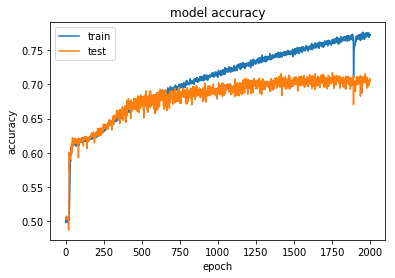

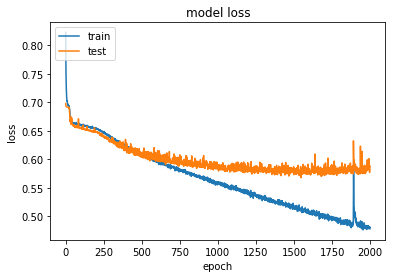

In [25]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
y_predprob = model.predict(x_test)
y_pred = model.predict_classes(x_test)
y_pred_decoded = Headlines.int_to_journal(data, y_pred)

y_trpred = model.predict_classes(x_train)
y_trpred_decoded = Headlines.int_to_journal(data, y_trpred)

In [27]:
y_train_tocat = Headlines.onehot_to_categorical(data, y_train)
y_test_tocat = Headlines.onehot_to_categorical(data, y_test)

In [28]:
#Print model report:
print ("\nModel Report")
print ("Accuracy (train set): %.4g" % metrics.accuracy_score(y_train_tocat, y_trpred))
print ("Accuracy (test set): %.4g" % metrics.accuracy_score(y_test_tocat, y_pred))
print("Confusion matrix:")
print (metrics.confusion_matrix(y_test_tocat, y_pred))
print("Detailed classification report:")
print (metrics.classification_report(y_test_tocat, y_pred))


Model Report
Accuracy (train set): 0.864
Accuracy (test set): 0.71
Confusion matrix:
[[1358  699]
 [ 524 1636]]
Detailed classification report:
             precision    recall  f1-score   support

          0       0.72      0.66      0.69      2057
          1       0.70      0.76      0.73      2160

avg / total       0.71      0.71      0.71      4217



# Desciptive statistics

In [ ]:
# number of words for abc headlines?
ep_headlines = min_per_df.loc[min_per_df["Journal"]=="El Pais", "Headline"]
ep_headlines

In [ ]:
#ep_long = str.split(ep_headlines)
ep_len = ep_headlines.apply(lambda x:len(text.text_to_word_sequence(unidecode(x), lower=True, split=" ", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'))).tolist()

In [ ]:
# Histogram
bins = np.arange(0, 22, 1) # fixed bin size
plt.xlim([min(ep_len)-5, max(ep_len)+5])

plt.hist(ep_len, bins=bins, alpha=0.5, edgecolor='black', linewidth=1.2)
plt.title('Histogram counts of words El Pais')
plt.xlabel('number of words')
plt.ylabel('count')

plt.show()

In [ ]:
abc_headlines = min_per_df.loc[min_per_df["Journal"]=="ABC", "Headline"]

In [ ]:
abc_len = abc_headlines.apply(lambda x:len(text.text_to_word_sequence(unidecode(x), lower=True, split=" ", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'))).tolist()

In [ ]:
# Histogram
bins = np.arange(0, 22, 1) # fixed bin size
plt.xlim([min(ep_len)-5, max(ep_len)+5])

plt.hist(abc_len, bins=bins, alpha=0.5, edgecolor='black', linewidth=1.2)
plt.title('Histogram counts of words ABC')
plt.xlabel('number of words')
plt.ylabel('count')

plt.show()